In [1]:
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

# Simple NST/ Image Regeneration (Content part only) from VGG-19

- input: target image
- output: generate image like target image from noise image by using gradient descent

## References

- https://keras.io/examples/generative/neural_style_transfer/

# Load VGG-19 Model

In [2]:
# neural style transfer output

content_layers = ['block5_conv2']
style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1',
]

In [3]:
def load_vgg():
    vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
    # vgg.trainable = False
    
    # extracted feature
    layers = content_layers + style_layers
    outputs_dict = dict([(layer, vgg.get_layer(layer).output) for layer in layers])
    
    # model for nst
    feature_extractor = tf.keras.Model(inputs=vgg.input, outputs=outputs_dict)
    
    return feature_extractor

# Image Preprocessing

In [4]:
def preprocess_image(image_path, image_size=(500, 500)):
    """
        return: tensor type array. shape (1, height, width, channel).
    """
    
    
    img = tf.keras.preprocessing.image.load_img(
        image_path, target_size=image_size 
    )
    
    # image to numpy array shape (h, w, c)
    img = tf.keras.preprocessing.image.img_to_array(img)
    
    # to shape (1, h, w, c)
    img = np.expand_dims(img, axis=0)
#     img = tf.keras.applications.vgg19.preprocess_input(img)
    
    return tf.convert_to_tensor(img)

In [5]:
def deprocess_image(tensor_img):
    img = np.array(tensor_img.numpy()[0], dtype=np.float64)
#     img[:, :, 0] += 103.939
#     img[:, :, 1] += 116.779
#     img[:, :, 2] += 123.68
    
    return img.astype(np.uint8)

In [6]:
img_path = "./img/2valk.jpg"
img_tensor = preprocess_image(img_path)

In [7]:
img_tensor

<tf.Tensor: shape=(1, 500, 500, 3), dtype=float32, numpy=
array([[[[110., 116., 130.],
         [128., 131., 146.],
         [157., 159., 174.],
         ...,
         [ 19.,  27.,  46.],
         [ 23.,  31.,  50.],
         [ 19.,  27.,  46.]],

        [[121., 138., 148.],
         [150., 167., 177.],
         [113., 130., 140.],
         ...,
         [ 25.,  33.,  56.],
         [ 23.,  31.,  54.],
         [ 24.,  32.,  55.]],

        [[166., 172., 184.],
         [136., 150., 163.],
         [138., 155., 165.],
         ...,
         [ 22.,  32.,  59.],
         [ 16.,  26.,  53.],
         [ 21.,  31.,  58.]],

        ...,

        [[ 60.,  58.,  61.],
         [ 66.,  64.,  67.],
         [ 70.,  68.,  71.],
         ...,
         [218., 183., 153.],
         [218., 187., 156.],
         [214., 184., 150.]],

        [[ 67.,  65.,  68.],
         [ 61.,  59.,  62.],
         [ 54.,  52.,  55.],
         ...,
         [208., 167., 135.],
         [200., 165., 133.],
         

In [8]:
img_np = deprocess_image(img_tensor)

In [9]:
img_np

array([[[110, 116, 130],
        [128, 131, 146],
        [157, 159, 174],
        ...,
        [ 19,  27,  46],
        [ 23,  31,  50],
        [ 19,  27,  46]],

       [[121, 138, 148],
        [150, 167, 177],
        [113, 130, 140],
        ...,
        [ 25,  33,  56],
        [ 23,  31,  54],
        [ 24,  32,  55]],

       [[166, 172, 184],
        [136, 150, 163],
        [138, 155, 165],
        ...,
        [ 22,  32,  59],
        [ 16,  26,  53],
        [ 21,  31,  58]],

       ...,

       [[ 60,  58,  61],
        [ 66,  64,  67],
        [ 70,  68,  71],
        ...,
        [218, 183, 153],
        [218, 187, 156],
        [214, 184, 150]],

       [[ 67,  65,  68],
        [ 61,  59,  62],
        [ 54,  52,  55],
        ...,
        [208, 167, 135],
        [200, 165, 133],
        [219, 185, 150]],

       [[ 72,  70,  73],
        [ 65,  63,  66],
        [ 73,  71,  74],
        ...,
        [170, 122,  84],
        [169, 125,  88],
        [199, 156, 121]]

# Generated Image Tensor

In [10]:
def load_random_noise_tensor(img_tensor):
    random_noise = np.array(np.random.randint(0, 255, img_tensor.shape))
    gen_tensor = tf.Variable(random_noise, dtype=tf.float32)
    return gen_tensor

In [11]:
gen_tensor = load_random_noise_tensor(img_tensor)

# Compute Loss

In [12]:
def compute_content_loss(base_tensor, gen_tensor, content_layer='block1_conv1', loss_weight=1e-6):
    input_tensor = tf.concat([base_tensor, gen_tensor], axis=0)
    features = model(input_tensor)[content_layer]
    base_feature = features[0]
    gen_feature = features[1] 
    
    return loss_weight*tf.reduce_sum(tf.square(base_feature - gen_feature))

In [13]:
model = load_vgg()

In [14]:
# content layer
content_layer = 'block1_conv1'
output = model(img_tensor)

In [15]:
compute_content_loss(img_tensor, img_tensor)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

# Gradient

In [16]:
@tf.function
def compute_loss_and_grads(base_image_tensor, gen_image_tensor):
    with tf.GradientTape() as tape:
        loss = compute_content_loss(base_image_tensor, gen_image_tensor)
    grads = tape.gradient(loss, gen_image_tensor)
    return loss, grads

# Training Loop

In [17]:
def training_loop(base_tensor, gen_tensor, optimizer, max_iterations=10000):
    for i in range(1, max_iterations+1):
        if (i % 100 == 0) or (i == 1) or (i == max_iterations):
            loss, grads = compute_loss_and_grads(base_tensor, gen_tensor)
            optimizer.apply_gradients([(grads, gen_tensor)])
            print(f"iteration {i:8}, loss {loss:.2f}")
            
        # show image
        if (i % 1000 == 0) or (i == 1) or (i == max_iterations):
            fig = plt.figure(figsize=(5, 5))
            plt.title(f"iteration {i}")
            plt.imshow(deprocess_image(gen_tensor))
            plt.show()
        
        # save image
        if (i % 200 == 0) or (i == 1) or (i == max_iterations):
            save_img_arr = deprocess_image(gen_tensor)
            tf.keras.preprocessing.image.save_img(f"./regenerate_output_img/{i}.jpg", save_img_arr)
    
    fig = plt.figure(figsize=(5, 5))
    plt.title("final result")
    plt.imshow(deprocess_image(gen_tensor))
    plt.show()

In [18]:
optimizer = tf.keras.optimizers.SGD(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1000.0, decay_steps=500, decay_rate=0.9
    )
)

In [19]:
# load image
img_path = "./img/remember.jpg"
img_size = (500, 500)

# base image/target image tensor
img_tensor = preprocess_image(img_path, img_size)
# random image
gen_tensor = load_random_noise_tensor(img_tensor)

iteration        1, loss 119873.77


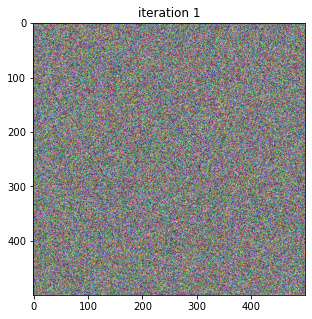

iteration      100, loss 112901.52
iteration      200, loss 106281.94
iteration      300, loss 99940.62
iteration      400, loss 93833.24
iteration      500, loss 87936.69
iteration      600, loss 82269.66
iteration      700, loss 76845.88
iteration      800, loss 71688.78
iteration      900, loss 66824.17
iteration     1000, loss 62274.84


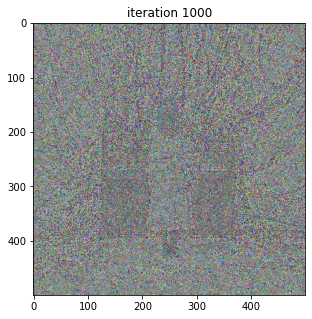

iteration     1100, loss 58051.04
iteration     1200, loss 54159.66
iteration     1300, loss 50597.30
iteration     1400, loss 47349.98
iteration     1500, loss 44400.89
iteration     1600, loss 41728.01
iteration     1700, loss 39308.06
iteration     1800, loss 37115.96
iteration     1900, loss 35128.56
iteration     2000, loss 33324.84


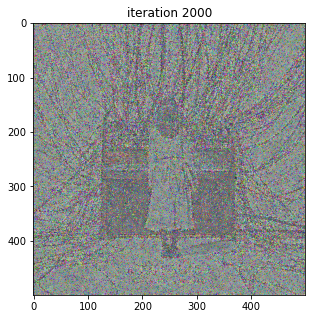

iteration     2100, loss 31684.47
iteration     2200, loss 30189.54
iteration     2300, loss 28823.11
iteration     2400, loss 27571.03
iteration     2500, loss 26420.43
iteration     2600, loss 25359.78
iteration     2700, loss 24379.02
iteration     2800, loss 23469.27
iteration     2900, loss 22622.91
iteration     3000, loss 21833.27


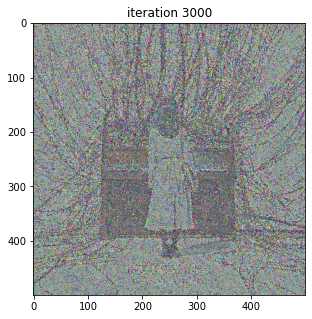

iteration     3100, loss 21094.46
iteration     3200, loss 20401.32
iteration     3300, loss 19749.38
iteration     3400, loss 19134.85
iteration     3500, loss 18554.25
iteration     3600, loss 18004.48
iteration     3700, loss 17482.84
iteration     3800, loss 16986.99
iteration     3900, loss 16514.74
iteration     4000, loss 16064.25


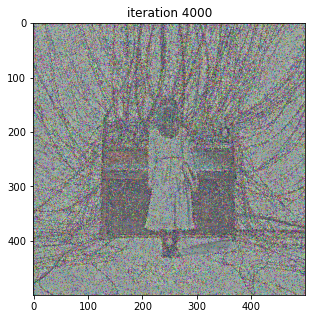

iteration     4100, loss 15633.86
iteration     4200, loss 15222.09
iteration     4300, loss 14827.66
iteration     4400, loss 14449.35
iteration     4500, loss 14086.03
iteration     4600, loss 13736.74
iteration     4700, loss 13400.62
iteration     4800, loss 13076.84
iteration     4900, loss 12764.68
iteration     5000, loss 12463.49


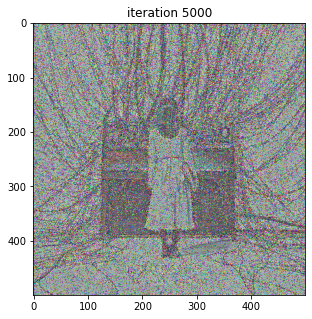

iteration     5100, loss 12172.64
iteration     5200, loss 11891.60
iteration     5300, loss 11619.85
iteration     5400, loss 11356.92
iteration     5500, loss 11102.36
iteration     5600, loss 10855.77
iteration     5700, loss 10616.77
iteration     5800, loss 10385.02
iteration     5900, loss 10160.20
iteration     6000, loss 9942.00


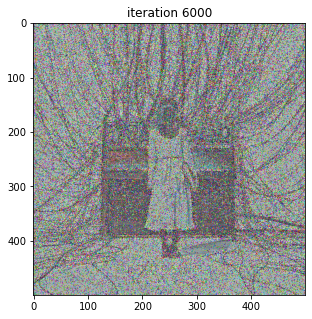

iteration     6100, loss 9730.13
iteration     6200, loss 9524.33
iteration     6300, loss 9324.33
iteration     6400, loss 9129.93
iteration     6500, loss 8940.88
iteration     6600, loss 8756.99
iteration     6700, loss 8578.06
iteration     6800, loss 8403.91
iteration     6900, loss 8234.35
iteration     7000, loss 8069.23


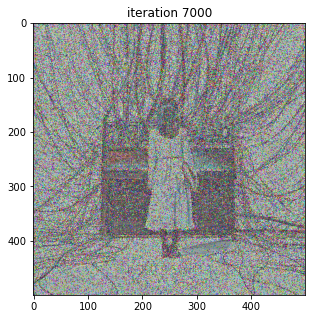

iteration     7100, loss 7908.39
iteration     7200, loss 7751.67
iteration     7300, loss 7598.92
iteration     7400, loss 7450.03
iteration     7500, loss 7304.85
iteration     7600, loss 7163.25
iteration     7700, loss 7025.13
iteration     7800, loss 6890.37
iteration     7900, loss 6758.87
iteration     8000, loss 6630.52


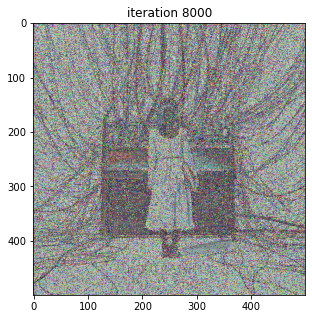

iteration     8100, loss 6505.23
iteration     8200, loss 6382.92
iteration     8300, loss 6263.48
iteration     8400, loss 6146.82
iteration     8500, loss 6032.88
iteration     8600, loss 5921.56
iteration     8700, loss 5812.80
iteration     8800, loss 5706.52
iteration     8900, loss 5602.66
iteration     9000, loss 5501.14


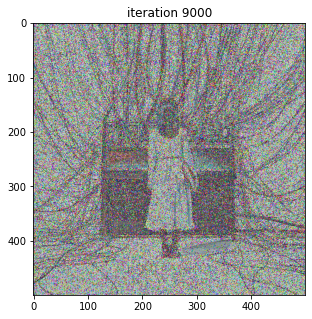

iteration     9100, loss 5401.90
iteration     9200, loss 5304.88
iteration     9300, loss 5210.02
iteration     9400, loss 5117.25
iteration     9500, loss 5026.52
iteration     9600, loss 4937.78
iteration     9700, loss 4850.98
iteration     9800, loss 4766.05
iteration     9900, loss 4682.97
iteration    10000, loss 4601.67


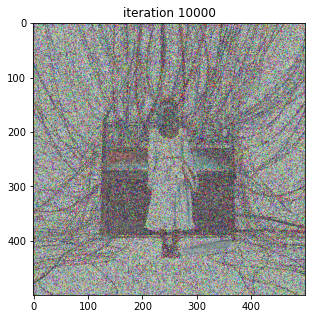

iteration    10100, loss 4522.12
iteration    10200, loss 4444.27
iteration    10300, loss 4368.06
iteration    10400, loss 4293.47
iteration    10500, loss 4220.46
iteration    10600, loss 4148.97
iteration    10700, loss 4078.99
iteration    10800, loss 4010.47
iteration    10900, loss 3943.38
iteration    11000, loss 3877.68


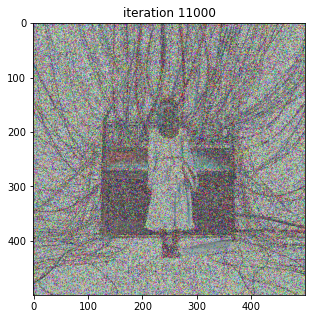

iteration    11100, loss 3813.34
iteration    11200, loss 3750.32
iteration    11300, loss 3688.59
iteration    11400, loss 3628.13
iteration    11500, loss 3568.90
iteration    11600, loss 3510.88
iteration    11700, loss 3454.03
iteration    11800, loss 3398.33
iteration    11900, loss 3343.75
iteration    12000, loss 3290.26


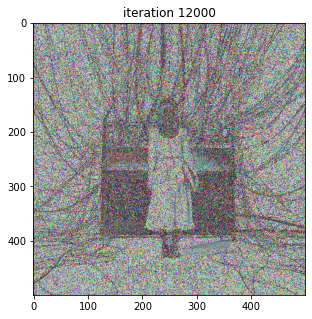

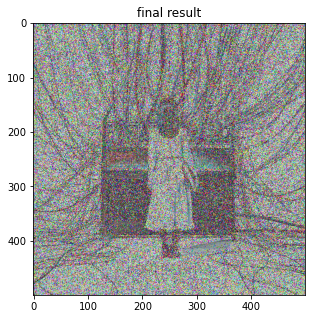

In [20]:
training_loop(img_tensor, gen_tensor, optimizer, 15000)

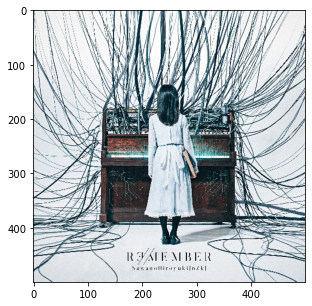

In [21]:
fig = plt.figure(figsize=(5, 5))
plt.imshow(deprocess_image(img_tensor))
plt.show()

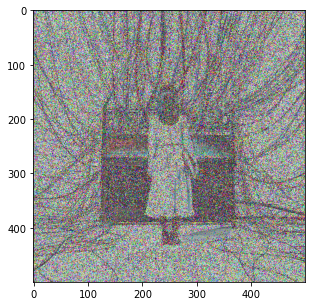

In [22]:
fig = plt.figure(figsize=(5, 5))
plt.imshow(deprocess_image(gen_tensor))
plt.show()